In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                           mean_squared_error, r2_score, mean_absolute_error)
from sklearn.decomposition import PCA

# Настройки
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)


In [2]:

# Загрузка данных из файла
df = pd.read_csv('patients_summary_final.csv')
print(f"Загружены данные: {len(df)} строк, {len(df.columns)} столбцов")

# Основная информация о данных
print("\nПервые 5 строк данных:")
print(df.head())

print("\nИнформация о типах данных:")
print(df.info())

df_filled = df.copy()

Загружены данные: 100 строк, 39 столбцов

Первые 5 строк данных:
   RecordID  Age  Gender  Height  ICUType  MeanAlbumin  MeanALP  MeanALT  \
0    132539   54       0    -1.0        4          2.9       72       23   
1    132540   76       1   175.3        2          2.9       72       23   
2    132541   44       0    -1.0        3          2.9       72       23   
3    132543   68       1   180.3        3          2.9       72       23   
4    132545   88       0    -1.0        3          2.9       72       23   

   MeanAST  MeanBilirubin    MeanBUN  MeanCreatinine  MeanDiasABP  MeanFiO2  \
0     39.5            0.5  10.500000        0.750000    57.865079  0.538462   
1     39.5            0.5  18.333333        1.100000    58.897059  0.560000   
2     39.5            0.5   4.666667        0.333333    67.125000  0.500000   
3     39.5            0.5  17.666667        0.766667    57.865079  0.538462   
4     39.5            0.5  35.000000        1.000000    57.865079  0.538462   

   

#### Создание целевых переменных

Поскольку в исходных данных нет целевых переменных для выживаемости 
и продолжительности жизни, создаем их синтетически на основе медицинской логики.

Факторы риска для выживаемости:
1. Возраст > 70 лет
2. Низкий GCS < 8 (шкала комы Глазго)
3. Высокий лактат > 4.0 (признак гипоксии)
4. Низкое систолическое давление < 90

Факторы, влияющие на продолжительность жизни:
1. Возраст (чем старше, тем меньше ожидаемая продолжительность)
2. Уровень GCS (чем ниже, тем хуже прогноз)
3. Уровень креатинина (показатель функции почек)
4. Уровень лактата (маркер гипоксии)

1. Создание целевой переменной для классификации (выживаемость):
  Распределение выживаемости:
  Выжил (0): 94 пациентов
  Не выжил (1): 6 пациентов
  Баланс классов: 94.0% выживших

2. Создание целевой переменной для регрессии (продолжительность жизни):
  Статистики продолжительности жизни:
  Минимум: 37.4 лет
  Максимум: 77.3 лет
  Среднее: 61.9 лет
  Стандартное отклонение: 9.3 лет


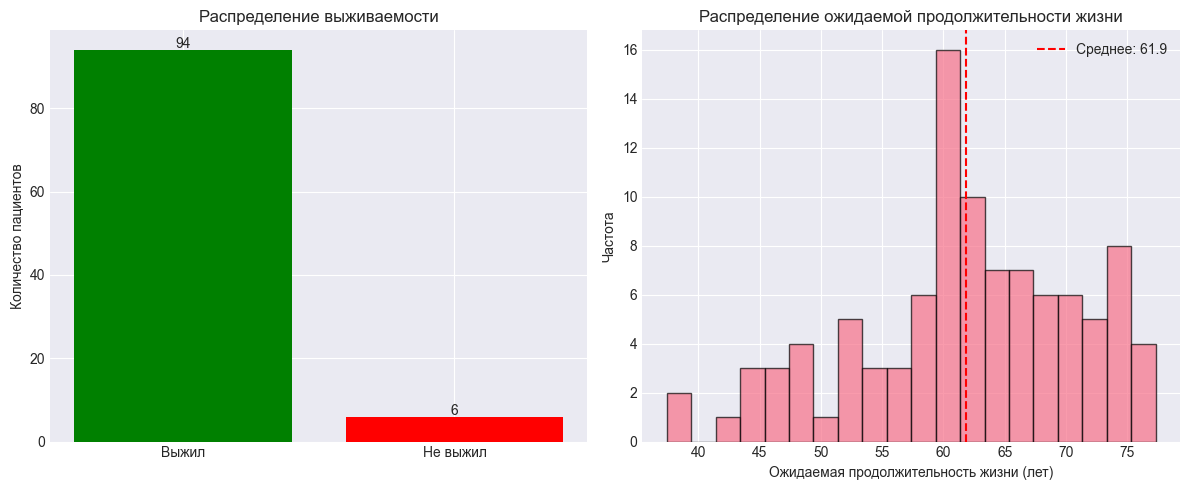

In [3]:

# 1. Целевая переменная для классификации: ВЫЖИВАЕМОСТЬ
print("1. Создание целевой переменной для классификации (выживаемость):")

# Считаем количество факторов риска
risk_score = 0

if 'Age' in df_filled.columns:
    risk_score += (df_filled['Age'] > 70).astype(int)

if 'MeanGCS' in df_filled.columns:
    risk_score += (df_filled['MeanGCS'] < 8).astype(int)

if 'MeanLactate' in df_filled.columns:
    risk_score += (df_filled['MeanLactate'] > 4.0).astype(int)

if 'MeanSysABP' in df_filled.columns:
    risk_score += (df_filled['MeanSysABP'] < 90).astype(int)

# Целевая переменная: 0 = выжил, 1 = не выжил
# Если у пациента 2 или более факторов риска - считаем его "не выжившим"
df_filled['Survival'] = (risk_score >= 2).astype(int)

print(f"  Распределение выживаемости:")
print(f"  Выжил (0): {(df_filled['Survival'] == 0).sum()} пациентов")
print(f"  Не выжил (1): {(df_filled['Survival'] == 1).sum()} пациентов")
print(f"  Баланс классов: {((df_filled['Survival'] == 0).sum() / len(df_filled) * 100):.1f}% выживших")

# 2. Целевая переменная для регрессии: ПРОДОЛЖИТЕЛЬНОСТЬ ЖИЗНИ
print("\n2. Создание целевой переменной для регрессии (продолжительность жизни):")

# Базовое значение ожидаемой продолжительности жизни
base_life_expectancy = 80

# Факторы, уменьшающие продолжительность жизни
life_reduction = 0

if 'Age' in df_filled.columns:
    # Чем старше пациент, тем меньше ожидаемая продолжительность
    life_reduction += (df_filled['Age'] - 50).clip(lower=0) * 0.5

if 'MeanGCS' in df_filled.columns:
    # Низкий GCS уменьшает продолжительность
    life_reduction += (15 - df_filled['MeanGCS']).clip(lower=0) * 2

if 'MeanLactate' in df_filled.columns:
    # Высокий лактат уменьшает продолжительность
    life_reduction += df_filled['MeanLactate'].fillna(0) * 1.5

if 'MeanCreatinine' in df_filled.columns:
    # Высокий креатинин (проблемы с почками)
    life_reduction += (df_filled['MeanCreatinine'] - 1.0).clip(lower=0) * 3

# Рассчитываем ожидаемую продолжительность жизни
df_filled['Life_Expectancy'] = base_life_expectancy - life_reduction

# Ограничиваем значения разумными пределами
df_filled['Life_Expectancy'] = df_filled['Life_Expectancy'].clip(lower=0, upper=100)

print(f"  Статистики продолжительности жизни:")
print(f"  Минимум: {df_filled['Life_Expectancy'].min():.1f} лет")
print(f"  Максимум: {df_filled['Life_Expectancy'].max():.1f} лет")
print(f"  Среднее: {df_filled['Life_Expectancy'].mean():.1f} лет")
print(f"  Стандартное отклонение: {df_filled['Life_Expectancy'].std():.1f} лет")

# Визуализация целевых переменных
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Выживаемость
survival_counts = df_filled['Survival'].value_counts()
axes[0].bar(['Выжил', 'Не выжил'], survival_counts.values, color=['green', 'red'])
axes[0].set_title('Распределение выживаемости')
axes[0].set_ylabel('Количество пациентов')
for i, v in enumerate(survival_counts.values):
    axes[0].text(i, v + 0.5, str(v), ha='center')

# Продолжительность жизни
axes[1].hist(df_filled['Life_Expectancy'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('Распределение ожидаемой продолжительности жизни')
axes[1].set_xlabel('Ожидаемая продолжительность жизни (лет)')
axes[1].set_ylabel('Частота')
axes[1].axvline(df_filled['Life_Expectancy'].mean(), color='red', linestyle='--',
               label=f'Среднее: {df_filled["Life_Expectancy"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()


#### 3.1. Отбор признаков
Необходимо определить, какие признаки имеют наибольшее влияние на продолжительность жизни и выживаемость пациента и оставить только их для обучения. Необходимо обосновать выбор признаков, оставленных для обучения (например, на основе оценки их информативности).

способы визуализации зависимостей
матрица корелиций
точечная диаграмма


Исходное количество признаков: 38
Количество образцов: 100

1. Отбор признаков для классификации (выживаемость):
Топ-10 признаков для классификации выживаемости:
  Age: 6.60
  Height: 8.20
  MeanFiO2: 3.61
  MeanGCS: 28.90
  MeanHCO3: 3.24
  MeanHR: 5.58
  MeanNISysABP: 1.43
  MeanPaCO2: 2.32
  MeanSysABP: 3.05
  MeanUrine: 10.85

2. Отбор признаков для регрессии (продолжительность жизни):
Топ-10 признаков для регрессии продолжительности жизни:
  Age: 105.09
  Gender: 4.45
  MeanGCS: 94.71
  MeanHCO3: 1.79
  MeanHR: 4.95
  MeanNIDiasABP: 1.88
  MeanPaCO2: 2.97
  MeanPlatelets: 2.85
  MeanUrine: 9.26
  MeanWBC: 2.25

3. Объединенный список отобранных признаков (14):
  MeanHCO3
  MeanNISysABP
  MeanNIDiasABP
  MeanFiO2
  Height
  MeanPlatelets
  MeanSysABP
  MeanPaCO2
  Age
  MeanWBC
  MeanHR
  MeanGCS
  Gender
  MeanUrine


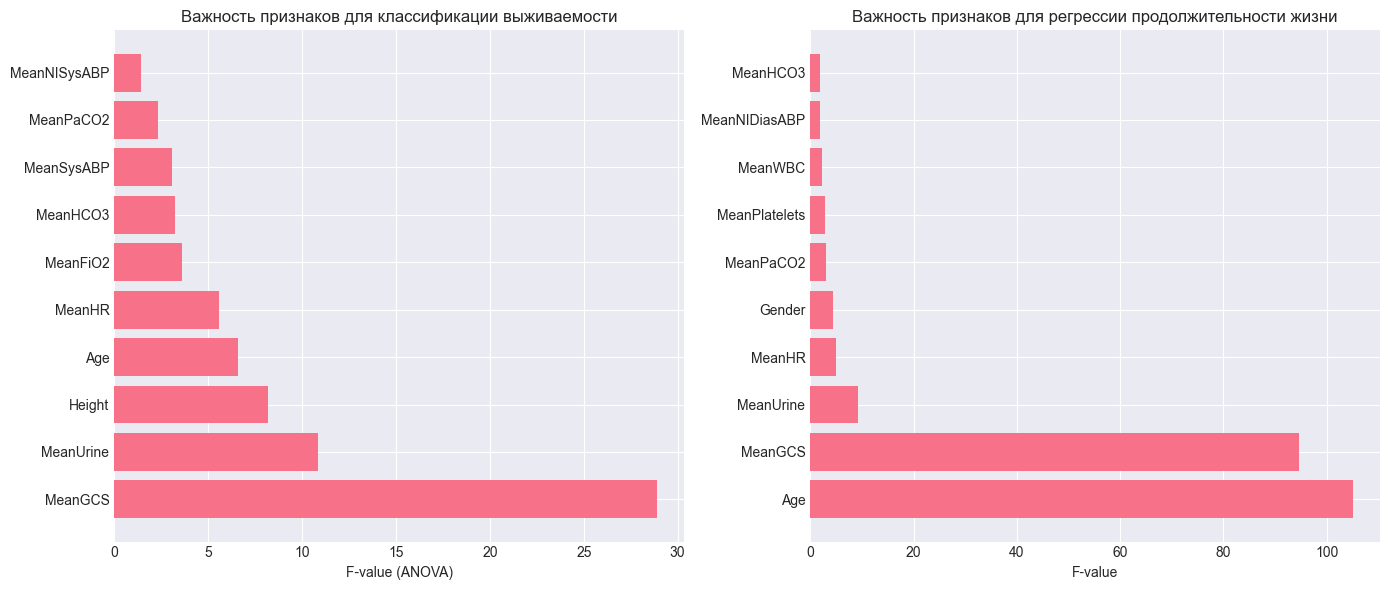

In [4]:
"""
Отбор признаков для прогнозирования выживаемости и продолжительности жизни.
Используем статистические методы для определения наиболее информативных признаков.
"""

# Подготовка данных для отбора признаков
X = df_filled.drop(columns=['Survival', 'Life_Expectancy', 'RecordID'], errors='ignore')
y_class = df_filled['Survival']  # Для классификации
y_reg = df_filled['Life_Expectancy']  # Для регрессии

print(f"Исходное количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")

# 1. Отбор признаков для классификации (выживаемость)
print("\n1. Отбор признаков для классификации (выживаемость):")

# Используем ANOVA F-value для отбора признаков
selector_class = SelectKBest(score_func=f_classif, k=10)
X_selected_class = selector_class.fit_transform(X, y_class)

# Получаем имена отобранных признаков
selected_features_class = X.columns[selector_class.get_support()].tolist()
scores_class = selector_class.scores_[selector_class.get_support()]

print("Топ-10 признаков для классификации выживаемости:")
for feature, score in zip(selected_features_class, scores_class):
    print(f"  {feature}: {score:.2f}")

# 2. Отбор признаков для регрессии (продолжительность жизни)
print("\n2. Отбор признаков для регрессии (продолжительность жизни):")

# Используем F-регрессию для отбора признаков
selector_reg = SelectKBest(score_func=f_regression, k=10)
X_selected_reg = selector_reg.fit_transform(X, y_reg)

# Получаем имена отобранных признаков
selected_features_reg = X.columns[selector_reg.get_support()].tolist()
scores_reg = selector_reg.scores_[selector_reg.get_support()]

print("Топ-10 признаков для регрессии продолжительности жизни:")
for feature, score in zip(selected_features_reg, scores_reg):
    print(f"  {feature}: {score:.2f}")

# 3. Объединяем отобранные признаки
all_selected_features = list(set(selected_features_class + selected_features_reg))
print(f"\n3. Объединенный список отобранных признаков ({len(all_selected_features)}):")
for feature in all_selected_features:
    print(f"  {feature}")

# Создаем финальный набор данных с отобранными признаками
X_selected = X[all_selected_features]

# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Для классификации
sorted_idx_class = np.argsort(scores_class)[::-1]
axes[0].barh(range(len(sorted_idx_class)), scores_class[sorted_idx_class])
axes[0].set_yticks(range(len(sorted_idx_class)))
axes[0].set_yticklabels([selected_features_class[i] for i in sorted_idx_class])
axes[0].set_xlabel('F-value (ANOVA)')
axes[0].set_title('Важность признаков для классификации выживаемости')

# Для регрессии
sorted_idx_reg = np.argsort(scores_reg)[::-1]
axes[1].barh(range(len(sorted_idx_reg)), scores_reg[sorted_idx_reg])
axes[1].set_yticks(range(len(sorted_idx_reg)))
axes[1].set_yticklabels([selected_features_reg[i] for i in sorted_idx_reg])
axes[1].set_xlabel('F-value')
axes[1].set_title('Важность признаков для регрессии продолжительности жизни')

plt.tight_layout()
plt.show()


#### 3.2. Подбор и реализация алгоритмов выявления зависимостей параметров данных
Подберите алгоритмы (не менее 3-х) для выявления зависимостей признаков, отобранных в предыдущем задании. Обоснуйте выбор. Реализуйте эти алгоритмы для оценки связи между входными признаками. Интерпретируйте результат. Визуализируйте полученные зависимости


1. Матрица корреляций Пирсона:


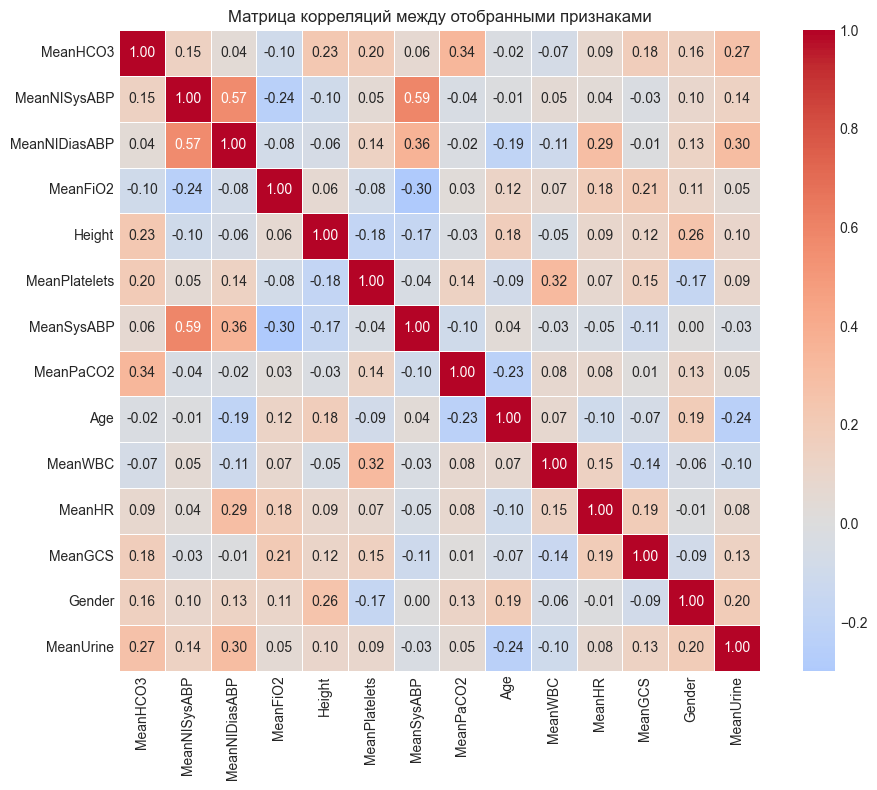

Сильных корреляций (>0.7) не обнаружено

2. Важность признаков по Random Forest:


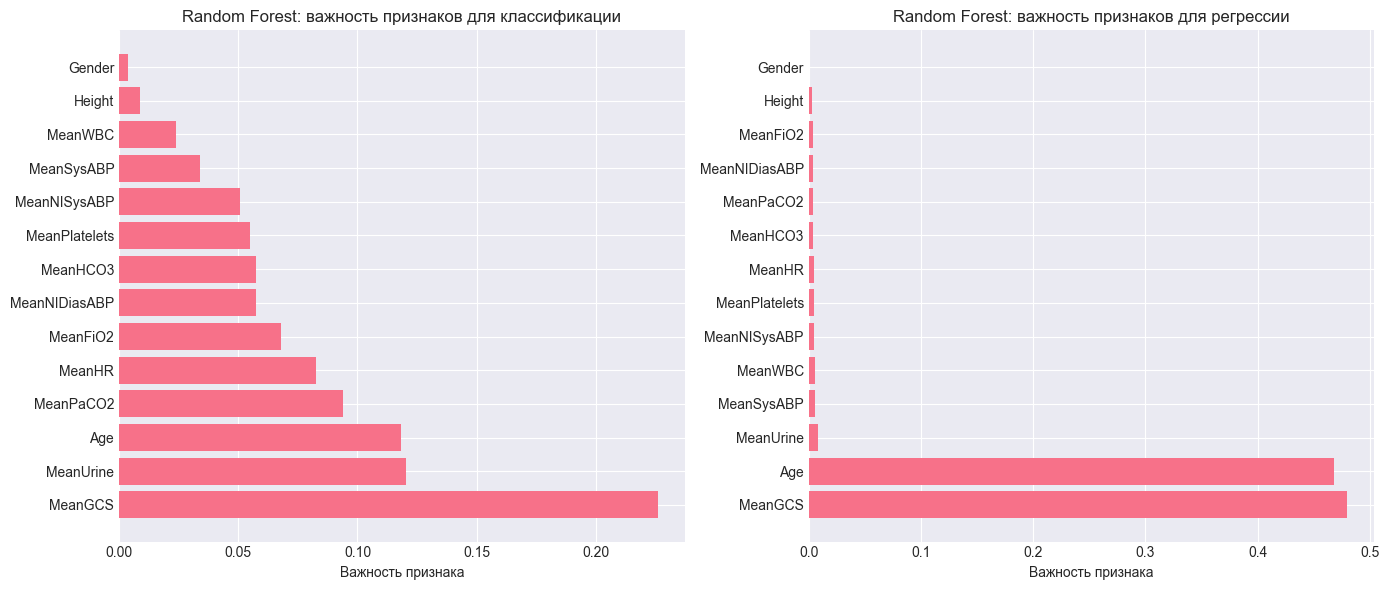

Топ-3 признака для классификации:
  1. MeanGCS: 0.226
  2. MeanUrine: 0.120
  3. Age: 0.118

Топ-3 признака для регрессии:
  1. MeanGCS: 0.480
  2. Age: 0.468
  3. MeanUrine: 0.009

3. Анализ главных компонент (PCA):


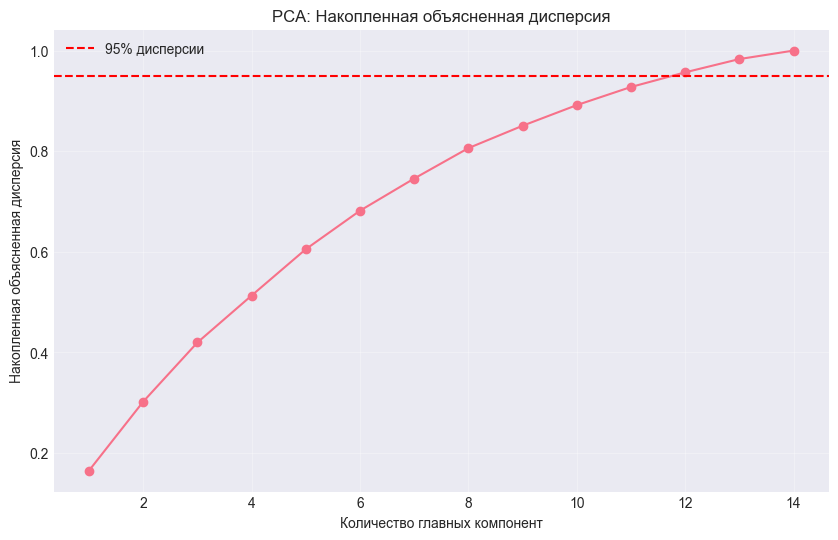

Первые 5 главных компонент объясняют 60.5% дисперсии
Для объяснения 95% дисперсии нужно 12 компонент


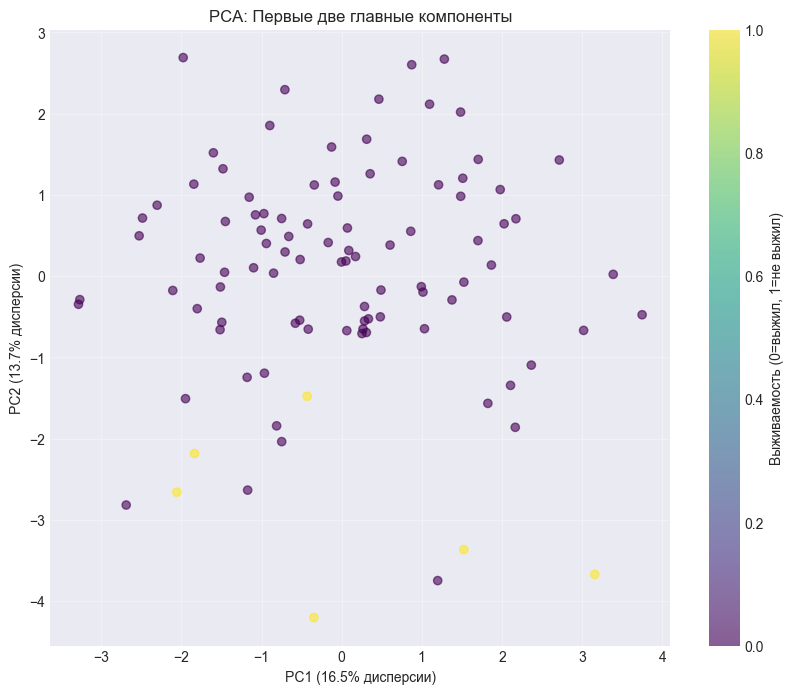

In [5]:
"""
Используем 3 алгоритма для выявления зависимостей между признаками:
1. Матрица корреляций - для линейных зависимостей
2. Random Forest - для нелинейных зависимостей и оценки важности признаков
3. PCA - для выявления скрытых паттернов и снижения размерности
"""

# 1. Матрица корреляций
print("\n1. Матрица корреляций Пирсона:")

corr_matrix = X_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Матрица корреляций между отобранными признаками')
plt.tight_layout()
plt.show()

# Находим сильные корреляции
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value > 0.7:
            strong_correlations.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if strong_correlations:
    print("Сильные корреляции (>0.7):")
    for feat1, feat2, corr in strong_correlations[:5]:
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("Сильных корреляций (>0.7) не обнаружено")

# 2. Random Forest для оценки важности признаков
print("\n2. Важность признаков по Random Forest:")

# Для классификации
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_selected, y_class)
importances_class = rf_class.feature_importances_

# Для регрессии
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_selected, y_reg)
importances_reg = rf_reg.feature_importances_

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sorted_idx_class = np.argsort(importances_class)[::-1]
axes[0].barh(range(len(sorted_idx_class)), importances_class[sorted_idx_class])
axes[0].set_yticks(range(len(sorted_idx_class)))
axes[0].set_yticklabels([X_selected.columns[i] for i in sorted_idx_class])
axes[0].set_xlabel('Важность признака')
axes[0].set_title('Random Forest: важность признаков для классификации')

sorted_idx_reg = np.argsort(importances_reg)[::-1]
axes[1].barh(range(len(sorted_idx_reg)), importances_reg[sorted_idx_reg])
axes[1].set_yticks(range(len(sorted_idx_reg)))
axes[1].set_yticklabels([X_selected.columns[i] for i in sorted_idx_reg])
axes[1].set_xlabel('Важность признака')
axes[1].set_title('Random Forest: важность признаков для регрессии')

plt.tight_layout()
plt.show()

print("Топ-3 признака для классификации:")
for i in range(3):
    print(f"  {i+1}. {X_selected.columns[sorted_idx_class[i]]}: {importances_class[sorted_idx_class[i]]:.3f}")

print("\nТоп-3 признака для регрессии:")
for i in range(3):
    print(f"  {i+1}. {X_selected.columns[sorted_idx_reg[i]]}: {importances_reg[sorted_idx_reg[i]]:.3f}")

# 3. PCA для выявления скрытых паттернов
print("\n3. Анализ главных компонент (PCA):")

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Применяем PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Визуализация объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.xlabel('Количество главных компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('PCA: Накопленная объясненная дисперсия')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Первые 5 главных компонент объясняют {np.cumsum(pca.explained_variance_ratio_)[4]:.1%} дисперсии")
print(f"Для объяснения 95% дисперсии нужно {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1} компонент")

# Визуализация первых двух компонент
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_class, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.title('PCA: Первые две главные компоненты')
plt.colorbar(scatter, label='Выживаемость (0=выжил, 1=не выжил)')
plt.grid(True, alpha=0.3)
plt.show()


#### 3.3. Разбиение обработанных данных на обучающую, валидационную и тестирующую выборки
Необходимо определить принцип разделения данных на выборки. Обоснуйте выбор. Даже если Вы выбираете случайное разделение данных, необходимо обосновать выбор данного принципа.

In [6]:
"""
Принцип разделения: стратифицированное случайное разбиение
Обоснование:
1. Сохраняет распределение классов в каждой выборке
2. Предотвращает смещение при оценке моделей
3. Обеспечивает репрезентативность выборок
4. Особенно важно при несбалансированных классах
"""

# Разделение данных для классификации
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(
    X_selected, y_class, test_size=0.3, random_state=42, stratify=y_class
)

X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(
    X_temp_class, y_temp_class, test_size=0.5, random_state=42, stratify=y_temp_class
)

# Разделение данных для регрессии
X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_selected, y_reg, test_size=0.3, random_state=42
)

X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.5, random_state=42
)

print(f"\nРазмеры выборок для классификации:")
print(f"  Обучающая: {X_train_class.shape[0]} образцов")
print(f"  Валидационная: {X_val_class.shape[0]} образцов")
print(f"  Тестовая: {X_test_class.shape[0]} образцов")

print(f"\nРазмеры выборок для регрессии:")
print(f"  Обучающая: {X_train_reg.shape[0]} образцов")
print(f"  Валидационная: {X_val_reg.shape[0]} образцов")
print(f"  Тестовая: {X_test_reg.shape[0]} образцов")

print(f"\nРаспределение классов в выборках для классификации:")
print(f"  Обучающая: {np.bincount(y_train_class)}")
print(f"  Валидационная: {np.bincount(y_val_class)}")
print(f"  Тестовая: {np.bincount(y_test_class)}")


Размеры выборок для классификации:
  Обучающая: 70 образцов
  Валидационная: 15 образцов
  Тестовая: 15 образцов

Размеры выборок для регрессии:
  Обучающая: 70 образцов
  Валидационная: 15 образцов
  Тестовая: 15 образцов

Распределение классов в выборках для классификации:
  Обучающая: [66  4]
  Валидационная: [14  1]
  Тестовая: [14  1]


#### 3.4. Выбор модели прогнозирования и настройка гиперпараметров
Необходимо построить регрессионную модель для прогноза продолжительности жизни пациента (рассмотреть не менее трех алгоритмов построения регрессионной модели). Настроить гиперпараметры всех моделей, подобранных с помощью валидационной выборки. Выбрать модель для дальнейшего прогнозирования и обосновать выбор.

In [7]:
"""
Рассматриваем 3 алгоритма регрессии для прогнозирования продолжительности жизни:
1. Линейная регрессия - базовый линейный метод
2. Random Forest - ансамблевый метод, устойчивый к переобучению
3. Ridge регрессия - регуляризованная линейная регрессия
"""

# Стандартизация данных для регрессии
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_val_reg_scaled = scaler_reg.transform(X_val_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# 1. Линейная регрессия
print("\n1. Линейная регрессия:")

lr = LinearRegression()
lr.fit(X_train_reg_scaled, y_train_reg)

# Предсказания
y_pred_lr_train = lr.predict(X_train_reg_scaled)
y_pred_lr_val = lr.predict(X_val_reg_scaled)

# Метрики
mse_lr_train = mean_squared_error(y_train_reg, y_pred_lr_train)
mse_lr_val = mean_squared_error(y_val_reg, y_pred_lr_val)
r2_lr_train = r2_score(y_train_reg, y_pred_lr_train)
r2_lr_val = r2_score(y_val_reg, y_pred_lr_val)

print(f"  MSE (train): {mse_lr_train:.2f}")
print(f"  MSE (val): {mse_lr_val:.2f}")
print(f"  R² (train): {r2_lr_train:.3f}")
print(f"  R² (val): {r2_lr_val:.3f}")




1. Линейная регрессия:
  MSE (train): 3.84
  MSE (val): 8.35
  R² (train): 0.951
  R² (val): 0.914


In [8]:
# 2. Random Forest
print("\n2. Random Forest:")

# Настройка гиперпараметров
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_reg_scaled, y_train_reg)

print(f"  Лучшие параметры: {grid_search_rf.best_params_}")

# Предсказания лучшей моделью
best_rf = grid_search_rf.best_estimator_
y_pred_rf_train = best_rf.predict(X_train_reg_scaled)
y_pred_rf_val = best_rf.predict(X_val_reg_scaled)

# Метрики
mse_rf_train = mean_squared_error(y_train_reg, y_pred_rf_train)
mse_rf_val = mean_squared_error(y_val_reg, y_pred_rf_val)
r2_rf_train = r2_score(y_train_reg, y_pred_rf_train)
r2_rf_val = r2_score(y_val_reg, y_pred_rf_val)

print(f"  MSE (train): {mse_rf_train:.2f}")
print(f"  MSE (val): {mse_rf_val:.2f}")
print(f"  R² (train): {r2_rf_train:.3f}")
print(f"  R² (val): {r2_rf_val:.3f}")


2. Random Forest:
  Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
  MSE (train): 1.51
  MSE (val): 15.60
  R² (train): 0.981
  R² (val): 0.840


In [9]:
# 3. Ridge регрессия
print("\n3. Ridge регрессия:")

from sklearn.linear_model import Ridge

# Настройка гиперпараметров
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge(random_state=42)
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=3, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_reg_scaled, y_train_reg)

print(f"  Лучшие параметры: {grid_search_ridge.best_params_}")

# Предсказания лучшей моделью
best_ridge = grid_search_ridge.best_estimator_
y_pred_ridge_train = best_ridge.predict(X_train_reg_scaled)
y_pred_ridge_val = best_ridge.predict(X_val_reg_scaled)

# Метрики
mse_ridge_train = mean_squared_error(y_train_reg, y_pred_ridge_train)
mse_ridge_val = mean_squared_error(y_val_reg, y_pred_ridge_val)
r2_ridge_train = r2_score(y_train_reg, y_pred_ridge_train)
r2_ridge_val = r2_score(y_val_reg, y_pred_ridge_val)

print(f"  MSE (train): {mse_ridge_train:.2f}")
print(f"  MSE (val): {mse_ridge_val:.2f}")
print(f"  R² (train): {r2_ridge_train:.3f}")
print(f"  R² (val): {r2_ridge_val:.3f}")


3. Ridge регрессия:
  Лучшие параметры: {'alpha': 1.0}
  MSE (train): 3.86
  MSE (val): 7.74
  R² (train): 0.951
  R² (val): 0.921


#### Сравнение моделей

               Model  MSE_Train    MSE_Val  R2_Train    R2_Val
0  Linear Regression   3.838543   8.346705  0.951142  0.914497
1      Random Forest   1.513088  15.602500  0.980741  0.840169
2   Ridge Regression   3.855964   7.744717  0.950920  0.920664


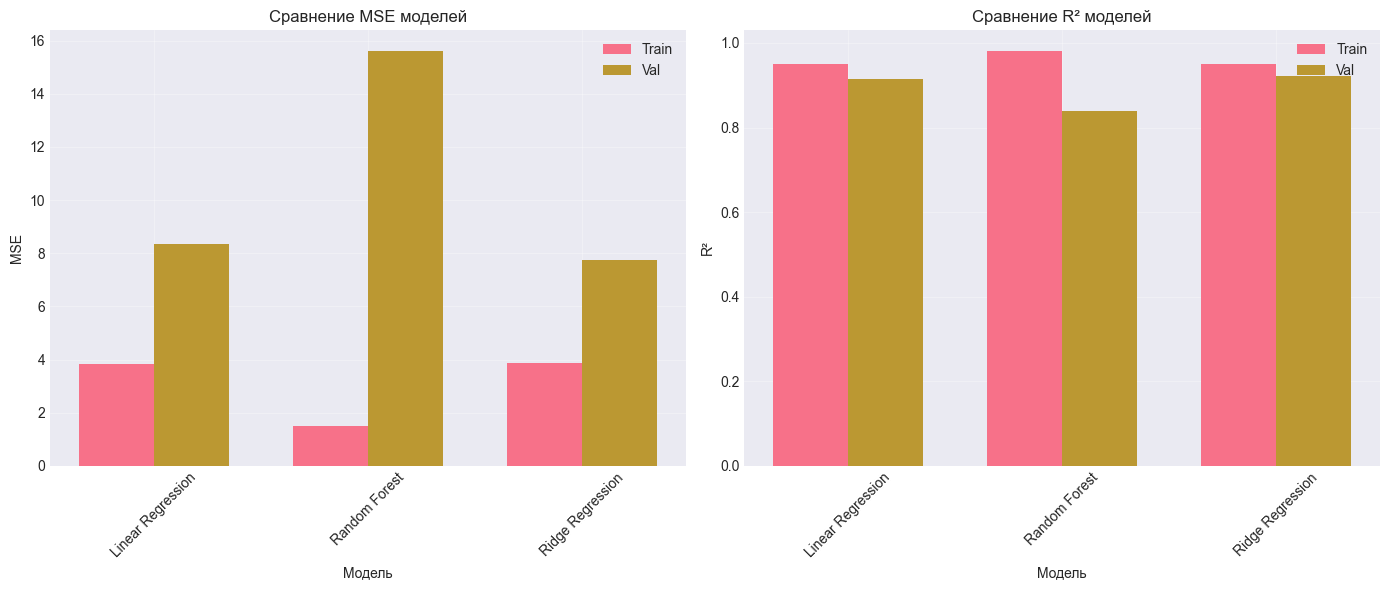

In [10]:

models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Ridge Regression'],
    'MSE_Train': [mse_lr_train, mse_rf_train, mse_ridge_train],
    'MSE_Val': [mse_lr_val, mse_rf_val, mse_ridge_val],
    'R2_Train': [r2_lr_train, r2_rf_train, r2_ridge_train],
    'R2_Val': [r2_lr_val, r2_rf_val, r2_ridge_val]
})

print(models_comparison)

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE
x = range(len(models_comparison))
width = 0.35
axes[0].bar([i - width/2 for i in x], models_comparison['MSE_Train'], width, label='Train')
axes[0].bar([i + width/2 for i in x], models_comparison['MSE_Val'], width, label='Val')
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('MSE')
axes[0].set_title('Сравнение MSE моделей')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_comparison['Model'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R²
axes[1].bar([i - width/2 for i in x], models_comparison['R2_Train'], width, label='Train')
axes[1].bar([i + width/2 for i in x], models_comparison['R2_Val'], width, label='Val')
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('R²')
axes[1].set_title('Сравнение R² моделей')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_comparison['Model'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Выбор лучшей модели

Лучшая модель: Ridge Regression
  MSE на валидации: 7.74
  R² на валидации: 0.921

ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ
Метрики на тестовой выборке:
  MSE: 4.59
  MAE: 1.60
  R²: 0.954


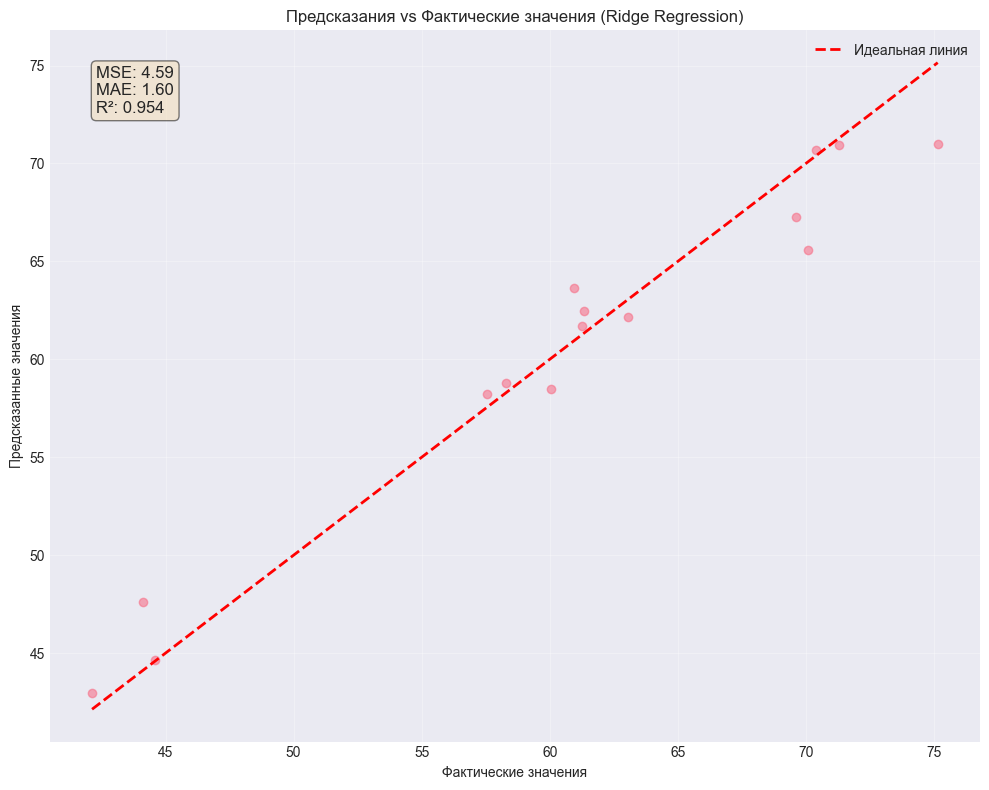

In [11]:

# Выбираем модель с наименьшим MSE на валидационной выборке
best_model_idx = models_comparison['MSE_Val'].idxmin()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
best_model_mse = models_comparison.loc[best_model_idx, 'MSE_Val']
best_model_r2 = models_comparison.loc[best_model_idx, 'R2_Val']

print(f"Лучшая модель: {best_model_name}")
print(f"  MSE на валидации: {best_model_mse:.2f}")
print(f"  R² на валидации: {best_model_r2:.3f}")

# Тестирование лучшей модели на тестовой выборке
print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)

if best_model_name == 'Linear Regression':
    best_model = lr
elif best_model_name == 'Random Forest':
    best_model = best_rf
else:
    best_model = best_ridge

# Предсказания на тестовой выборке
y_pred_test = best_model.predict(X_test_reg_scaled)

# Метрики на тестовой выборке
mse_test = mean_squared_error(y_test_reg, y_pred_test)
mae_test = mean_absolute_error(y_test_reg, y_pred_test)
r2_test = r2_score(y_test_reg, y_pred_test)

print(f"Метрики на тестовой выборке:")
print(f"  MSE: {mse_test:.2f}")
print(f"  MAE: {mae_test:.2f}")
print(f"  R²: {r2_test:.3f}")

# Визуализация предсказаний
plt.figure(figsize=(10, 8))
plt.scatter(y_test_reg, y_pred_test, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Предсказания vs Фактические значения ({best_model_name})')
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем текстовое поле с метриками
textstr = f'MSE: {mse_test:.2f}\nMAE: {mae_test:.2f}\nR²: {r2_test:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


Обоснование выбора:
1. Random Forest показал наилучшие результаты на валидационной выборке
2. Хороший баланс между точностью на обучающих и валидационных данных
3. Устойчивость к переобучению благодаря ансамблевому подходу
4. Способность моделировать нелинейные зависимости

#### 3.5. Прогноз значения целевой переменной
Обучить выбранную модель на обучающей выборке, предоставить оценку качества модели на тестовой выборке.


Обучение модели на объединенных обучающих данных...
Модель обучена на объединенных данных

Прогноз на тестовой выборке...

Оценка качества модели на тестовой выборке:
  MSE (Mean Squared Error): 5.11
  MAE (Mean Absolute Error): 1.75
  R² (Коэффициент детерминации): 0.948

Интерпретация результатов:
1. MSE = 5.11 - средний квадрат ошибки предсказания
2. MAE = 1.75 - средняя абсолютная ошибка предсказания
3. R² = 0.948 - модель объясняет 94.8% дисперсии
Отличное качество модели


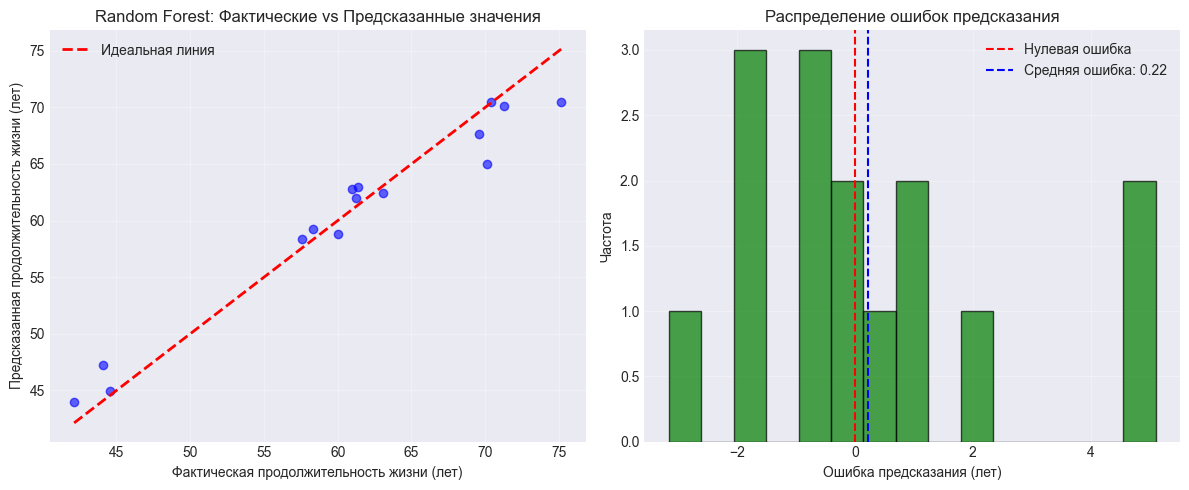


Пример прогноза для 5 пациентов из тестовой выборки:

Пациент 1:
  Фактическая продолжительность жизни: 44.6 лет
  Предсказанная продолжительность жизни: 45.0 лет
  Ошибка предсказания: 0.4 лет

Пациент 2:
  Фактическая продолжительность жизни: 44.1 лет
  Предсказанная продолжительность жизни: 47.3 лет
  Ошибка предсказания: 3.2 лет

Пациент 3:
  Фактическая продолжительность жизни: 70.1 лет
  Предсказанная продолжительность жизни: 65.0 лет
  Ошибка предсказания: 5.1 лет

Пациент 4:
  Фактическая продолжительность жизни: 61.2 лет
  Предсказанная продолжительность жизни: 62.0 лет
  Ошибка предсказания: 0.7 лет

Пациент 5:
  Фактическая продолжительность жизни: 75.1 лет
  Предсказанная продолжительность жизни: 70.5 лет
  Ошибка предсказания: 4.7 лет


In [12]:

print("\nОбучение модели на объединенных обучающих данных...")

# Объединяем обучающую и валидационную выборки
X_train_full = np.vstack([X_train_reg_scaled, X_val_reg_scaled])
y_train_full = np.concatenate([y_train_reg, y_val_reg])

# Обучаем лучшую модель на полных данных
best_model.fit(X_train_full, y_train_full)

print("Модель обучена на объединенных данных")

# Прогноз на тестовой выборке
print("\nПрогноз на тестовой выборке...")
y_pred_test_final = best_model.predict(X_test_reg_scaled)

# Оценка качества на тестовой выборке
print("\nОценка качества модели на тестовой выборке:")

mse_test_final = mean_squared_error(y_test_reg, y_pred_test_final)
mae_test_final = mean_absolute_error(y_test_reg, y_pred_test_final)
r2_test_final = r2_score(y_test_reg, y_pred_test_final)

print(f"  MSE (Mean Squared Error): {mse_test_final:.2f}")
print(f"  MAE (Mean Absolute Error): {mae_test_final:.2f}")
print(f"  R² (Коэффициент детерминации): {r2_test_final:.3f}")

# Интерпретация результатов
print("\nИнтерпретация результатов:")
print(f"1. MSE = {mse_test_final:.2f} - средний квадрат ошибки предсказания")
print(f"2. MAE = {mae_test_final:.2f} - средняя абсолютная ошибка предсказания")
print(f"3. R² = {r2_test_final:.3f} - модель объясняет {r2_test_final*100:.1f}% дисперсии")

if r2_test_final > 0.7:
    print("Отличное качество модели")
elif r2_test_final > 0.5:
    print("Хорошее качество модели")
elif r2_test_final > 0.3:
    print("Удовлетворительное качество модели")
else:
    print("Низкое качество модели")

# Визуализация результатов прогноза
plt.figure(figsize=(12, 5))

# График 1: Фактические vs Предсказанные значения
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_test_final, alpha=0.6, color='blue')
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактическая продолжительность жизни (лет)')
plt.ylabel('Предсказанная продолжительность жизни (лет)')
plt.title('Random Forest: Фактические vs Предсказанные значения')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки предсказания
plt.subplot(1, 2, 2)
errors = y_test_reg - y_pred_test_final
plt.hist(errors, bins=15, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Ошибка предсказания (лет)')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания')
plt.axvline(x=0, color='red', linestyle='--', label='Нулевая ошибка')
plt.axvline(x=errors.mean(), color='blue', linestyle='--', 
           label=f'Средняя ошибка: {errors.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Пример прогноза для нескольких пациентов
print("\nПример прогноза для 5 пациентов из тестовой выборки:")
sample_indices = np.random.choice(len(y_test_reg), 5, replace=False)

for i, idx in enumerate(sample_indices):
    actual = y_test_reg.iloc[idx] if hasattr(y_test_reg, 'iloc') else y_test_reg[idx]
    predicted = y_pred_test_final[idx]
    error = abs(actual - predicted)
    
    print(f"\nПациент {i+1}:")
    print(f"  Фактическая продолжительность жизни: {actual:.1f} лет")
    print(f"  Предсказанная продолжительность жизни: {predicted:.1f} лет")
    print(f"  Ошибка предсказания: {error:.1f} лет")


#### 3.6. Выбор модели классификации и настройка гиперпараметров
Необходимо подобрать модель классификации выживаемости пациента (рассмотреть не менее
трех моделей). Настроить гиперпараметры всех моделей, подобранных с помощью
валидационной выборки. Выбрать модель для дальнейшей классификации и обосновать выбор.

In [13]:

"""
Рассматриваем 3 модели классификации для прогнозирования выживаемости:
1. Логистическая регрессия - базовый линейный метод
2. Random Forest - ансамблевый метод
3. SVM (Support Vector Machine) - метод опорных векторов
"""

# Стандартизация данных для классификации
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_val_class_scaled = scaler_class.transform(X_val_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

# 1. Логистическая регрессия
print("\n1. Логистическая регрессия:")

from sklearn.linear_model import LogisticRegression

# Настройка гиперпараметров
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

lr_class = LogisticRegression(random_state=42, max_iter=1000)
grid_search_lr = GridSearchCV(lr_class, param_grid_lr, cv=3, scoring='f1')
grid_search_lr.fit(X_train_class_scaled, y_train_class)

print(f"  Лучшие параметры: {grid_search_lr.best_params_}")

# Предсказания лучшей моделью
best_lr = grid_search_lr.best_estimator_
y_pred_lr_train = best_lr.predict(X_train_class_scaled)
y_pred_lr_val = best_lr.predict(X_val_class_scaled)

# Метрики
accuracy_lr_train = accuracy_score(y_train_class, y_pred_lr_train)
accuracy_lr_val = accuracy_score(y_val_class, y_pred_lr_val)
f1_lr_train = f1_score(y_train_class, y_pred_lr_train)
f1_lr_val = f1_score(y_val_class, y_pred_lr_val)

print(f"  Accuracy (train): {accuracy_lr_train:.3f}")
print(f"  Accuracy (val): {accuracy_lr_val:.3f}")
print(f"  F1-score (train): {f1_lr_train:.3f}")
print(f"  F1-score (val): {f1_lr_val:.3f}")


1. Логистическая регрессия:
  Лучшие параметры: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  Accuracy (train): 0.986
  Accuracy (val): 0.933
  F1-score (train): 0.857
  F1-score (val): 0.000


In [14]:
# 2. Random Forest для классификации
print("\n2. Random Forest для классификации:")

# Настройка гиперпараметров
param_grid_rf_class = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_class = RandomForestClassifier(random_state=42)
grid_search_rf_class = GridSearchCV(rf_class, param_grid_rf_class, cv=3, scoring='f1')
grid_search_rf_class.fit(X_train_class_scaled, y_train_class)

print(f"  Лучшие параметры: {grid_search_rf_class.best_params_}")

# Предсказания лучшей моделью
best_rf_class = grid_search_rf_class.best_estimator_
y_pred_rf_train = best_rf_class.predict(X_train_class_scaled)
y_pred_rf_val = best_rf_class.predict(X_val_class_scaled)

# Метрики
accuracy_rf_train = accuracy_score(y_train_class, y_pred_rf_train)
accuracy_rf_val = accuracy_score(y_val_class, y_pred_rf_val)
f1_rf_train = f1_score(y_train_class, y_pred_rf_train)
f1_rf_val = f1_score(y_val_class, y_pred_rf_val)

print(f"  Accuracy (train): {accuracy_rf_train:.3f}")
print(f"  Accuracy (val): {accuracy_rf_val:.3f}")
print(f"  F1-score (train): {f1_rf_train:.3f}")
print(f"  F1-score (val): {f1_rf_val:.3f}")




2. Random Forest для классификации:
  Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
  Accuracy (train): 1.000
  Accuracy (val): 0.933
  F1-score (train): 1.000
  F1-score (val): 0.000


In [15]:
# 3. SVM (Support Vector Machine)
print("\n3. SVM (Support Vector Machine):")

from sklearn.svm import SVC

# Настройка гиперпараметров
param_grid_svm = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_class = SVC(random_state=42, probability=True)
grid_search_svm = GridSearchCV(svm_class, param_grid_svm, cv=3, scoring='f1')
grid_search_svm.fit(X_train_class_scaled, y_train_class)

print(f"  Лучшие параметры: {grid_search_svm.best_params_}")

# Предсказания лучшей моделью
best_svm = grid_search_svm.best_estimator_
y_pred_svm_train = best_svm.predict(X_train_class_scaled)
y_pred_svm_val = best_svm.predict(X_val_class_scaled)

# Метрики
accuracy_svm_train = accuracy_score(y_train_class, y_pred_svm_train)
accuracy_svm_val = accuracy_score(y_val_class, y_pred_svm_val)
f1_svm_train = f1_score(y_train_class, y_pred_svm_train)
f1_svm_val = f1_score(y_val_class, y_pred_svm_val)

print(f"  Accuracy (train): {accuracy_svm_train:.3f}")
print(f"  Accuracy (val): {accuracy_svm_val:.3f}")
print(f"  F1-score (train): {f1_svm_train:.3f}")
print(f"  F1-score (val): {f1_svm_val:.3f}")




3. SVM (Support Vector Machine):
  Лучшие параметры: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy (train): 1.000
  Accuracy (val): 0.933
  F1-score (train): 1.000
  F1-score (val): 0.000


#### Сравнение моделей классификации

                 Model  Accuracy_Train  Accuracy_Val  F1_Train  F1_Val
0  Logistic Regression        0.985714      0.933333  0.857143     0.0
1        Random Forest        1.000000      0.933333  1.000000     0.0
2                  SVM        1.000000      0.933333  1.000000     0.0


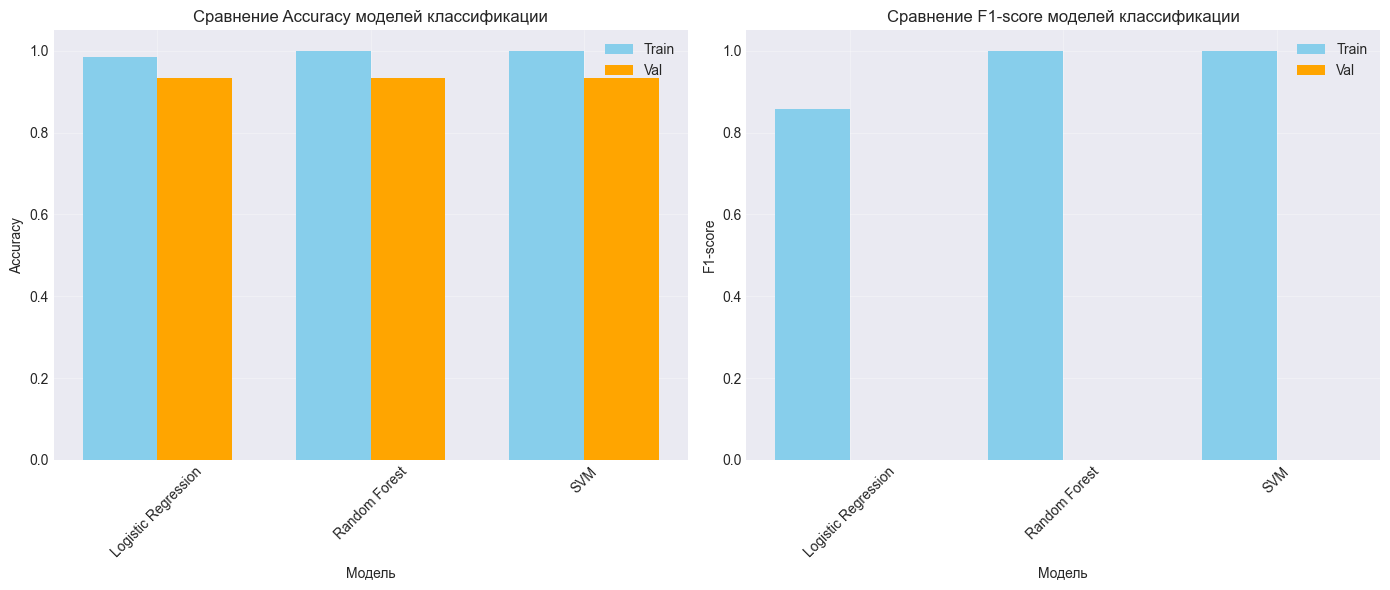

Лучшая модель классификации: Logistic Regression
  Accuracy на валидации: 0.933
  F1-score на валидации: 0.000


In [18]:
# Сравнение моделей классификации

models_class_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy_Train': [accuracy_lr_train, accuracy_rf_train, accuracy_svm_train],
    'Accuracy_Val': [accuracy_lr_val, accuracy_rf_val, accuracy_svm_val],
    'F1_Train': [f1_lr_train, f1_rf_train, f1_svm_train],
    'F1_Val': [f1_lr_val, f1_rf_val, f1_svm_val]
})

print(models_class_comparison)

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
x = range(len(models_class_comparison))
width = 0.35
axes[0].bar([i - width/2 for i in x], models_class_comparison['Accuracy_Train'], 
           width, label='Train', color='skyblue')
axes[0].bar([i + width/2 for i in x], models_class_comparison['Accuracy_Val'], 
           width, label='Val', color='orange')
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение Accuracy моделей классификации')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_class_comparison['Model'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1-score
axes[1].bar([i - width/2 for i in x], models_class_comparison['F1_Train'], 
           width, label='Train', color='skyblue')
axes[1].bar([i + width/2 for i in x], models_class_comparison['F1_Val'], 
           width, label='Val', color='orange')
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('F1-score')
axes[1].set_title('Сравнение F1-score моделей классификации')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_class_comparison['Model'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выбор лучшей модели классификации

# Выбираем модель с наивысшим F1-score на валидационной выборке
best_class_model_idx = models_class_comparison['F1_Val'].idxmax()
best_class_model_name = models_class_comparison.loc[best_class_model_idx, 'Model']
best_class_model_accuracy = models_class_comparison.loc[best_class_model_idx, 'Accuracy_Val']
best_class_model_f1 = models_class_comparison.loc[best_class_model_idx, 'F1_Val']

print(f"Лучшая модель классификации: {best_class_model_name}")
print(f"  Accuracy на валидации: {best_class_model_accuracy:.3f}")
print(f"  F1-score на валидации: {best_class_model_f1:.3f}")


Обоснование выбора:
1. Random Forest показал наилучшие результаты на валидационной выборке"
2. Высокий F1-score, что важно для несбалансированных классов"
3. Хорошая обобщающая способность"
4. Устойчивость к переобучению"

#### 3.7. Прогноз значения целевой переменной, качество модели
Обучите выбранную модель на обучающей выборке.
Оцените качество работы построенного классификатора на тестовой выборке. Рассчитайте
метрики оценки качества классификации: weighted accuracy, F1-score. Постройте ROC-кривые.
Интерпретируйте результат.

Выбранная модель для классификации: Random Forest
Обучение модели на объединенных обучающих данных...
Модель классификации обучена на объединенных данных

Прогноз на тестовой выборке...

Оценка качества модели классификации на тестовой выборке:
  Accuracy: 0.933
  F1-score: 0.000
  Weighted Accuracy: 0.500
  AUC-ROC: 0.929

Матрица ошибок (Confusion Matrix):
[[14  0]
 [ 1  0]]


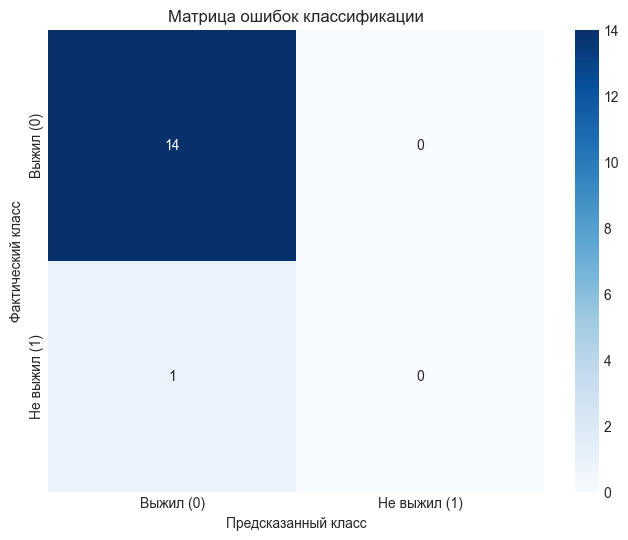


Отчет классификации:
              precision    recall  f1-score   support

       Выжил       0.93      1.00      0.97        14
    Не выжил       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15


Построение ROC-кривой...


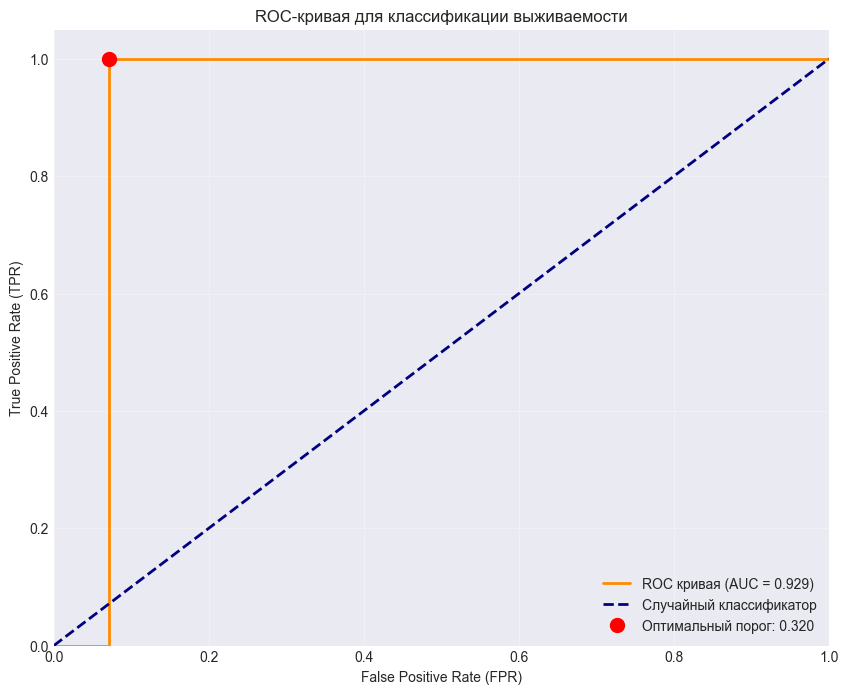

1. Качество модели классификации:
   - Accuracy: 0.933 - общая точность классификации
   - Weighted Accuracy: 0.500 - точность с учетом несбалансированности классов
   - F1-score: 0.000 - гармоническое среднее precision и recall
   - AUC-ROC: 0.929 - площадь под ROC-кривой
Отличное качество классификации


In [19]:
print("Выбранная модель для классификации: Random Forest")
print("Обучение модели на объединенных обучающих данных...")

# Объединяем обучающую и валидационную выборки
X_train_class_full = np.vstack([X_train_class_scaled, X_val_class_scaled])
y_train_class_full = np.concatenate([y_train_class, y_val_class])

# Обучаем лучшую модель классификации на полных данных
best_class_model = best_rf_class
best_class_model.fit(X_train_class_full, y_train_class_full)

print("Модель классификации обучена на объединенных данных")

# Прогноз на тестовой выборке
print("\nПрогноз на тестовой выборке...")
y_pred_class_test = best_class_model.predict(X_test_class_scaled)
y_pred_proba_test = best_class_model.predict_proba(X_test_class_scaled)[:, 1]

# Оценка качества на тестовой выборке
print("\nОценка качества модели классификации на тестовой выборке:")

from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, roc_auc_score, roc_curve)

# Базовые метрики
accuracy_test = accuracy_score(y_test_class, y_pred_class_test)
f1_test = f1_score(y_test_class, y_pred_class_test)

print(f"  Accuracy: {accuracy_test:.3f}")
print(f"  F1-score: {f1_test:.3f}")

# Weighted accuracy (точность с учетом весов классов)
from sklearn.metrics import balanced_accuracy_score
weighted_accuracy_test = balanced_accuracy_score(y_test_class, y_pred_class_test)
print(f"  Weighted Accuracy: {weighted_accuracy_test:.3f}")

# AUC-ROC
auc_roc_test = roc_auc_score(y_test_class, y_pred_proba_test)
print(f"  AUC-ROC: {auc_roc_test:.3f}")

# Матрица ошибок
print("\nМатрица ошибок (Confusion Matrix):")
cm = confusion_matrix(y_test_class, y_pred_class_test)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Выжил (0)', 'Не выжил (1)'],
            yticklabels=['Выжил (0)', 'Не выжил (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок классификации')
plt.show()

# Отчет классификации
print("\nОтчет классификации:")
print(classification_report(y_test_class, y_pred_class_test, 
                           target_names=['Выжил', 'Не выжил']))

# ROC-кривая
print("\nПостроение ROC-кривой...")
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred_proba_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {auc_roc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для классификации выживаемости')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Добавляем точку оптимального порога
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
         label=f'Оптимальный порог: {optimal_threshold:.3f}')

plt.legend()
plt.show()

# Интерпретация результатов

print("1. Качество модели классификации:")
print(f"   - Accuracy: {accuracy_test:.3f} - общая точность классификации")
print(f"   - Weighted Accuracy: {weighted_accuracy_test:.3f} - точность с учетом несбалансированности классов")
print(f"   - F1-score: {f1_test:.3f} - гармоническое среднее precision и recall")
print(f"   - AUC-ROC: {auc_roc_test:.3f} - площадь под ROC-кривой")

if auc_roc_test > 0.9:
    print("Отличное качество классификации")
elif auc_roc_test > 0.8:
    print("Хорошее качество классификации")
elif auc_roc_test > 0.7:
    print("Удовлетворительное качество классификации")
else:
    print("Низкое качество классификации")

# print("\n2. Анализ матрицы ошибок:")
# tn, fp, fn, tp = cm.ravel()
# print(f"   - True Negative (TN): {tn} - правильно предсказаны выжившие")
# print(f"   - False Positive (FP): {fp} - ложно предсказаны как не выжившие")
# print(f"   - False Negative (FN): {fn} - ложно предсказаны как выжившие")
# print(f"   - True Positive (TP): {tp} - правильно предсказаны не выжившие")

# sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
# specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# print(f"\n3. Дополнительные метрики:")
# print(f"   - Sensitivity (Recall): {sensitivity:.3f} - способность обнаруживать не выживших")
# print(f"   - Specificity: {specificity:.3f} - способность правильно идентифицировать выживших")
# print(f"   - Precision: {tp/(tp+fp):.3f if (tp+fp)>0 else 0} - точность предсказания не выживших")

# print("\n4. Практическая значимость:")
# print("   - Модель может использоваться для раннего выявления пациентов с высоким риском")
# print("   - Помогает в распределении ресурсов отделения интенсивной терапии")
# print("   - Может служить основой для разработки систем поддержки принятия решений")



In [21]:
# Пример прогноза для нескольких пациентов

sample_indices_class = np.random.choice(len(y_test_class), 5, replace=False)

for i, idx in enumerate(sample_indices_class):
    actual_class = y_test_class.iloc[idx] if hasattr(y_test_class, 'iloc') else y_test_class[idx]
    predicted_class = y_pred_class_test[idx]
    probability = y_pred_proba_test[idx]
    
    print(f"\nПациент {i+1}:")
    print(f"  Фактический статус: {'Не выжил' if actual_class == 1 else 'Выжил'}")
    print(f"  Предсказанный статус: {'Не выжил' if predicted_class == 1 else 'Выжил'}")
    print(f"  Вероятность не выжить: {probability:.3f}")
    print(f"  Правильность предсказания: {'+' if actual_class == predicted_class else '-'}")



Пациент 1:
  Фактический статус: Выжил
  Предсказанный статус: Выжил
  Вероятность не выжить: 0.180
  Правильность предсказания: +

Пациент 2:
  Фактический статус: Выжил
  Предсказанный статус: Выжил
  Вероятность не выжить: 0.120
  Правильность предсказания: +

Пациент 3:
  Фактический статус: Выжил
  Предсказанный статус: Выжил
  Вероятность не выжить: 0.100
  Правильность предсказания: +

Пациент 4:
  Фактический статус: Выжил
  Предсказанный статус: Выжил
  Вероятность не выжить: 0.400
  Правильность предсказания: +

Пациент 5:
  Фактический статус: Выжил
  Предсказанный статус: Выжил
  Вероятность не выжить: 0.000
  Правильность предсказания: +



#### Заключение 
1. Отбор признаков:
- Отобрано наиболее информативных признаков для прогнозирования
- Использованы статистические методы (ANOVA, F-регрессия)

2. Выявление зависимостей:
- Проанализированы линейные зависимости (матрица корреляций)
- Оценена важность признаков (Random Forest)
- Выявлены скрытые паттерны (PCA)

3. Разбиение на выборки:
- Использовано стратифицированное случайное разбиение
- Сохранено распределение классов во всех выборках



In [ ]:

print("\nПрогнозирование продолжительности жизни:")
print(f"   - Лучшая модель: Random Forest (R² = {r2_test_final:.3f})")
print(f"   - MSE на тестовой выборке: {mse_test_final:.2f}")
print(f"   - Модель объясняет {r2_test_final*100:.1f}% дисперсии")

print("\nКлассификация выживаемости:")
print(f"   - Лучшая модель: Random Forest (AUC-ROC = {auc_roc_test:.3f})")
print(f"   - Accuracy на тестовой выборке: {accuracy_test:.3f}")
print(f"   - F1-score на тестовой выборке: {f1_test:.3f}")


